Sentiment analysis of movie (IMDB) reviews using dataset provided by the ACL 2011 paper, 
see http://ai.stanford.edu/~amaas/data/sentiment/
This notebook uses neural net models

The plan is to try a variety of neural net based models:
* dense neural network with bag of words
* dense neural network with fixed size input and words mapped to integers
* LSTM
* CNN


In [2]:
import numpy as np
import os
import os.path
import glob
import time

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import nltk
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
nltk.download('punkt')
import nltk
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /Users/Eric/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
from sklearn.model_selection import KFold

In [2]:
import wget
import tarfile

# By checking if the directory exists first, we allow people to delete the tarfile without the notebook re-downloading it
if os.path.isdir('aclImdb'):
    print("Dataset directory exists, taking no action")
else:    
    if not os.path.isfile('aclImdb_v1.tar.gz'):
        print("Downloading dataset")
        #!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
        wget.download('http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
    else:
        print("Dataset already downloaded")
    
    print("Unpacking dataset")
    #!tar -xf aclImdb_v1.tar.gz 
    tar = tarfile.open("aclImdb_v1.tar.gz")
    tar.extractall()
    tar.close()
    print("Dataset unpacked in aclImdb")

ModuleNotFoundError: No module named 'wget'

In [3]:
# configuration
SAMPLE_SIZE=1000

## Load data

In [4]:
time_beginning_of_notebook = time.time()
positive_file_list = glob.glob(os.path.join('aclImdb/train/pos', "*.txt"))
positive_sample_file_list = positive_file_list[:SAMPLE_SIZE]

negative_file_list = glob.glob(os.path.join('aclImdb/train/neg', "*.txt"))
negative_sample_file_list = negative_file_list[:SAMPLE_SIZE]

import re

# load doc into memory
# regex to clean markup elements 
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r', encoding='utf8')
    # read all text
    text = re.sub('<[^>]*>', ' ', file.read())
    #text = file.read()
    # close the file
    file.close()
    return text

In [5]:
positive_strings = [load_doc(x) for x in positive_sample_file_list]
negative_strings = [load_doc(x) for x in negative_sample_file_list]

positive_tokenized = [word_tokenize(s) for s in positive_strings]
negative_tokenized = [word_tokenize(s) for s in negative_strings]

In [6]:
from collections import Counter
import numpy as np

In [7]:
total_counts = Counter()
all_reviews = positive_tokenized + negative_tokenized
for r in all_reviews:
    for word in r:
        total_counts[word] += 1

In [8]:
vocab = set(total_counts.keys())

In [9]:
vocab_size = len(vocab)
print(vocab_size)

33535


In [10]:
# Create a dictionary of words in the vocabulary mapped to index positions
# (to be used in layer_0)
word2index = {}
for i,word in enumerate(vocab):
    word2index[word] = i

In [11]:
print("ID of 'movie' = {}".format(word2index['movie']))

ID of 'movie' = 17884


In [12]:
def convert_to_bag(review):
    bag = np.zeros(vocab_size)
    for word in review:
        i = word2index[word]
        bag[i]+=1
    return bag

In [13]:
test_bag = convert_to_bag(all_reviews[0])


In [14]:
all_reviews_encoded = [convert_to_bag(x) for x in all_reviews]

In [15]:
all_reviews_encoded[0].shape

(33535,)

In [ ]:
#all_reviews_trunc = np.trunc()

In [12]:
# display the map of words to indices
print("word indexes = {}".format(word2index))

word indexes = {'typeset': 0, 'honesty': 1, 'nudes': 2, 'Culp': 3, 'step-father': 4, 'Code': 5, 'fetishism': 6, '_discussing_': 7, 'HALLOWEEN': 8, 'MONTMARTRE': 9, 'haze': 10, 'celebrate': 11, 'seaward': 12, 'slapper': 13, 'push-ups': 14, 'Rijn': 15, 'M|might': 16, 'Zealand': 17, 'Destroyer': 18, 'now': 19, 'cover': 20, 'warned': 21, 'gym': 22, 'step-daughter': 23, 'aswell': 24, 'tempted': 25, 'Chawla': 26, 'apparel': 27, 'Judging': 28, 'Clarkson': 29, 'Curator': 30, 'Rochefort': 31, 'slain': 32, 'Murders': 33, 'softcore': 34, 'firstly': 35, 'rewired': 36, 'Pastorelli': 37, 'Robbery': 38, 'cake': 39, 'wheel': 40, 'MacNicol': 41, 'Timento': 42, 'unlimited': 43, 'Wild': 44, "'It": 45, 'prospect': 46, 'slack': 47, 'MAKER': 48, 'subtexts': 49, 'landfill': 50, 'morter': 51, 'Heahthrow': 52, 'McIntyre': 53, 'Thomas': 54, 'Esther': 55, 'Hauptmann': 56, 'Latin': 57, 'dads': 58, 'Apanowicz': 59, 'Clevemore': 60, "O'Conor": 61, 'token': 62, 'trove': 63, 'loving': 64, 'sabre': 65, 'detects': 66, 

In [16]:
import random

positive_labels = []
for i in range(len(positive_tokenized)):
    positive_labels.append('POSITIVE')
negative_labels = []
for i in range(len(negative_tokenized)):
    negative_labels.append('NEGATIVE')
   

In [17]:
labels = positive_labels + negative_labels

num_lables = []

for val in labels:
    if val == 'POSITIVE':
       num_lables.append(1)
    else:
       num_lables.append(0) 
    

In [18]:
reviews_and_labels = list(zip(all_reviews_encoded, num_lables))
random.shuffle(reviews_and_labels)
reviews, labels = zip(*reviews_and_labels)

In [19]:
labels = np.array(labels)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [21]:
model = keras.Sequential()
model.add(layers.Dense(50, activation = "relu", input_shape=(vocab_size, )))
model.add(layers.Dense(10, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1676800   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,677,321
Trainable params: 1,677,321
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

In [23]:
results = model.fit(
 X_train, y_train,
 epochs= 5,
 validation_data=(X_test, y_test),
batch_size=500
)

Train on 1500 samples, validate on 500 samples
Epoch 1/5
1500/1500 [==============================] - 1s 827us/step - loss: 0.6835 - acc: 0.5853 - val_loss: 0.6380 - val_acc: 0.7020
Epoch 2/5
1500/1500 [==============================] - 1s 347us/step - loss: 0.5554 - acc: 0.8507 - val_loss: 0.5836 - val_acc: 0.7420
Epoch 3/5
1500/1500 [==============================] - 1s 343us/step - loss: 0.4194 - acc: 0.9340 - val_loss: 0.5113 - val_acc: 0.8060
Epoch 4/5
1500/1500 [==============================] - 0s 325us/step - loss: 0.3033 - acc: 0.9760 - val_loss: 0.4623 - val_acc: 0.8320
Epoch 5/5
1500/1500 [==============================] - 1s 355us/step - loss: 0.2126 - acc: 0.9880 - val_loss: 0.4341 - val_acc: 0.8300


In [75]:
model = keras.Sequential([
    layers.Dense(256, activation = "relu", input_shape=(vocab_size, )),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
])

In [76]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               8585216   
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 8,618,241
Trainable params: 8,618,241
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

In [97]:
results = model.fit(
 X_train, y_train,
 epochs= 1,
 validation_data=(X_test, y_test),
batch_size=500
)

Train on 1500 samples, validate on 500 samples
Epoch 1/1
1500/1500 [==============================] - 1s 838us/step - loss: 0.6072 - acc: 0.7560 - val_loss: 0.5949 - val_acc: 0.7400


In [131]:
results.history

{'val_loss': [0.6677807569503784,
  0.6592906713485718,
  0.5849310159683228,
  0.5346614122390747,
  0.4845280051231384],
 'val_acc': [0.5559999942779541,
  0.6200000047683716,
  0.7599999904632568,
  0.7639999985694885,
  0.8140000104904175],
 'loss': [0.6995466947555542,
  0.6015947461128235,
  0.51310133934021,
  0.3896384537220001,
  0.2997811436653137],
 'acc': [0.47600001096725464,
  0.7070000171661377,
  0.8920000195503235,
  0.9860000014305115,
  0.9679999947547913]}

### Training with K-Fold cross validation


In [79]:
X_train, X_test, y_train, y_test = train_test_split(np.array(reviews), np.array(labels), test_size=0.25)

In [80]:
kfold = KFold(3, True, 1)

In [81]:
train_data = list(zip(X_train, y_train))

In [82]:
train_data[0][0].shape

(33535,)

In [135]:
histories=[]
for train_indices, test_indices in kfold.split(X_train,y=y_train):
    model = keras.Sequential([
    layers.Dense(256, activation = "relu", input_shape=(vocab_size, )),
    layers.Dense(128, activation = "relu"),
    layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(
     optimizer = "adam",
     loss = "binary_crossentropy",
     metrics = ["accuracy"]
    )
    K_X_train = X_train[train_indices]
    K_y_train = y_train[train_indices]
    K_X_test = X_train[test_indices]
    K_y_test = y_train[test_indices]
    results=model.fit(
        K_X_train, K_y_train,
        epochs= 5,
        validation_data=(K_X_test, K_y_test),
        batch_size=1000
    )
    histories.append(results.history)

Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6967 - acc: 0.4880 - val_loss: 0.7444 - val_acc: 0.5000
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.6558 - acc: 0.5250 - val_loss: 0.6464 - val_acc: 0.6920
Epoch 3/5
1000/1000 [==============================] - 1s 917us/step - loss: 0.5257 - acc: 0.9870 - val_loss: 0.6662 - val_acc: 0.5960
Epoch 4/5
1000/1000 [==============================] - 1s 845us/step - loss: 0.4629 - acc: 0.9060 - val_loss: 0.5926 - val_acc: 0.7320
Epoch 5/5
1000/1000 [==============================] - 1s 861us/step - loss: 0.3422 - acc: 0.9950 - val_loss: 0.5458 - val_acc: 0.7560
Train on 1000 samples, validate on 500 samples
Epoch 1/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.7075 - acc: 0.4950 - val_loss: 0.7391 - val_acc: 0.4940
Epoch 2/5
1000/1000 [==============================] - 1s 860us/step - loss: 0.6951 - acc: 0.5080 - va

mean acc: 0.9776666760444641, mean val_acc: 0.7919999957084656


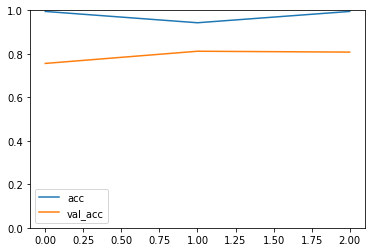

In [139]:
import pandas as pd
import matplotlib
df = pd.DataFrame(data=histories)
for col in df.columns:
    df[col] =  df[col].apply(lambda x: x[-1])
plot=df[["acc","val_acc"]].plot()
plot.set_ylim([0,1])

means=df[["acc","val_acc"]].mean()
print("mean acc: {}, mean val_acc: {}".format(means["acc"],means["val_acc"]))
